### visulaizing the  corine images

### The corine land cover classes

In [17]:
clcc ={111:'cont. urban fabric',
 112:'disc urban fabric',
 121:'industrial or commercial units',
 122:'road and rail',
 123:'port areas',
 124:'airports',
 131:'mineral extraction sites',
 132:'dump sites',
 133:'construction sites',
 141:'green urban areas',
 142:'sport and leasure',
 211:'non irregated arable land',
 212:'permenant irregated land',
 213:'rice fields',
 221:'vine yards',
 223:'olive groves',
 231:'pastures',
 241:'annual with perm. crops',
 242:'complex cultivation patters',
 243:'land principally occupied by agriculture',
 244:'agro forest areas',
 311:'broad leaved forest',
 312:'conferous forest',
 313:'mixed forest',
 321:'natural grassland',
 322:'moors and heathland',
 323: 'scierohllous vegitation',
 324:'transitional woodland shrub',
 331: 'beaches dunes and sand plains',
 332:'bare rock',
 333:'sparsely vegetated areas',
 334:'burnt areas',
 335:'glaciers and perpetual snow',
 411:'inland marshes',
 412:'peat bogs',
 421:'salt marshes',
 422:'salines',
 423:'intertidal flats',
 511:'water courses',
 512:'water bodies',
 521:'costal lagoons',
 522:'estuaries',
 523:'sea and ocean'}
 
 
















In [18]:
landcovers = [key for idx, key in enumerate(clcc) ]

In [19]:
len(landcovers)

43

### Algorithm to change a segmentation mask into a feature vector 
#### where each element represnts the number of pixels of each class in each segmentation mask
#### The first part is a dataloader for the segmentation mask and the labels of wild and non wild

In [3]:
#final code
# to do list is to build a transparent model to train on the classes
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import tifffile as tiff
import time
from tqdm import tqdm


class CustomDataset(Dataset):
    def __init__(self, csv_file, root):
        self.data = pd.read_csv(csv_file)
        
        self.image_paths = sorted(glob.glob(os.path.join(root)+ '/*.*'))
        #self.image_paths = (self.data['file'])
        #print(len(self.image_paths))
        #self.image_paths = sorted(glob.glob(os.path.join('/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs', self.image_paths)))
        self.labels = self.data['label']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        
        label = self.labels[idx]

        
        # we need to open the image as a tiff file and take the first channel representing the corine channel
        image = tiff.imread(image_path)
        image = image.astype('int')
        #print(image.shape)
        image = image[:,:,0]

        return image, label

# Path to the CSV file
csv_file = 'infos.csv'

# Create an instance of the custom dataset
dataset = CustomDataset(csv_file,root = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs')

# Create a data loader to iterate over the dataset
batch_size = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# code the image to segmentation mask function:
# to extract the corine channel from the path
#print(len(data_loader))
#print(images[0])
# Iterate over the data loader
array = landcovers
feature_array = []
target_labels = []
for images, labels in tqdm(data_loader):
    # Convert images to segmentation mask here using your own logic
    #print('-------loop is working-------')
    segmentation_mask = images
    #print(len(images))
    # Get the unique land cover classes present in the segmentation mask
    land_cover_classes = torch.unique(segmentation_mask)

    # Compute the number of land cover classes and the maximum number of classes expected
    num_classes = len(land_cover_classes)
    max_num_classes = 44  # Set the maximum number of land cover classes expected in the dataset
    
    
    # create a dictionary to have the key the land cover class code and as the ni. of pixels of this specific land cover class as data
    class_counts = {}
    
    
    
    # Generate the vector with the count of pixels for each land cover class
    
    for class_keys in land_cover_classes:
        class_counts = {key: 0 for key in array}

        if class_keys in landcovers: # to make sure that we only have the corine land cover classess
            

        
            class_rep = torch.sum(segmentation_mask == class_keys)
            #class_keys = class_keys.item
            #class_rep = class_rep.item

            class_counts[class_keys.item()] = class_rep.item()
            #print(class_counts)
            #time.sleep(1)
            
    #print('the label is -->',labels.item())
    # Trim the class_counts tensor to the actual number of classes found
    #class_counts = class_counts[:num_classes]
    
    # Print the class counts vector
    '''print("Class Counts:")
    print(class_counts.values())
   
    
    print('feature_array len-->',len(feature_array),'target_labels len-->',len(target_labels))
    print('feature_array -->',(feature_array),'target_labels -->',(target_labels))
    #print(labels)
    #time.sleep(0)'''
    
    
    feature_array.append(list(class_counts.values()))
    target_labels.append(labels.item())


NameError: name 'landcovers' is not defined

### Dataset and dataloader for the scene classification dataset (Anthroprotect dataset)

In [7]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images = self.data['file']
        self.labels = self.data['label']
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = self.images[index]  # Assuming the image names are in the first column of the CSV file
        image_label = self.labels[index]
        # Construct the complete image path by joining the folder path and image name
        image_path = os.path.join(self.image_folder, image_name)

        # Open the image using PIL
        image = tiff.imread(image_path)
        
        #choos ethe number of channels you need
        image= image[:,:,:3]
        #####
        
        image = image.astype('uint8')
        #image = image.astype('int')
        # Apply transformations, if provided
        if self.transform:
            #pil_image = Image.fromarray(image)
            image = self.transform(image)
            
        

            

        return image, image_label
    
    
csv_file =  'infos.csv'
image_folder = '~/working_folder/data/anthroprotect/tiles/s2'
transform = transforms.ToTensor()  # Example transformation, you can add more

dataset = CustomDataset(csv_file, image_folder, transform=transform) # Replace with your actual dataset instantiation

# Define the ratio of the dataset to be used for testing
test_ratio = 0.2

# Calculate the number of samples for testing
test_size = int(test_ratio * len(dataset))

# Calculate the number of samples for training
train_size = len(dataset) - test_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Example usage





In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize the image to (224, 224)
    transforms.ToTensor()  # Convert the PIL Image to tensor
])
scene_dataset= CustomDataset(csv_file, '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2',transform)


In [9]:
batch_size = 128  # Define the batch size
data_loader = DataLoader(scene_dataset, batch_size=batch_size, shuffle=True)

len(dataset)

23919

### a classifier for scence classification, with a method to extract a the embeddings from the bottelneck

In [11]:
import torch
import torch.nn as nn


import torch
import torch.nn as nn



class DeepClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DeepClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.embedding = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(10,1),
            nn.Sigmoid())
    
    def forward(self, x):
        features = self.features(x)
        flattened = torch.flatten(features, start_dim=1)
        embedding = self.embedding(flattened)
        output = self.classifier(embedding)
        
        return output, embedding

# Example usage
input_channels = 3
image_size = 256
num_classes = 1
model = DeepClassifier(num_classes)

model = model.to('cuda')

# Training the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training of the scene classifier

In [13]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
# Assuming you have your training data in a PyTorch DataLoader called "train_loader"
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    # Variables to keep track of accuracy and total samples
    total_loss = 0.0
    total_samples = 0
    
    for data in data_loader:
        inputs, labels = data  
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, encoded_data = model(inputs.float())
        
        
        
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        
        total_samples += inputs.size(0)
        
    mse = total_loss / total_samples
    print(f"Training MSE: {mse:.4f}")



Training Progress:   5%|█▎                       | 1/20 [01:00<19:03, 60.19s/it]

Training MSE: 0.0792


Training Progress:  10%|██▌                      | 2/20 [02:01<18:11, 60.63s/it]

Training MSE: 0.0658


Training Progress:  15%|███▊                     | 3/20 [03:00<17:04, 60.24s/it]

Training MSE: 0.0487


Training Progress:  20%|█████                    | 4/20 [04:01<16:05, 60.33s/it]

Training MSE: 0.0314


Training Progress:  25%|██████▎                  | 5/20 [05:01<15:05, 60.35s/it]

Training MSE: 0.0251


Training Progress:  30%|███████▌                 | 6/20 [06:01<14:04, 60.29s/it]

Training MSE: 0.0217


Training Progress:  35%|████████▊                | 7/20 [07:02<13:05, 60.44s/it]

Training MSE: 0.0179


Training Progress:  40%|██████████               | 8/20 [08:03<12:05, 60.44s/it]

Training MSE: 0.0134


Training Progress:  45%|███████████▎             | 9/20 [09:03<11:03, 60.29s/it]

Training MSE: 0.0127


Training Progress:  50%|████████████            | 10/20 [10:05<10:09, 60.94s/it]

Training MSE: 0.0105


Training Progress:  55%|█████████████▏          | 11/20 [11:06<09:09, 61.07s/it]

Training MSE: 0.0084


Training Progress:  60%|██████████████▍         | 12/20 [12:09<08:13, 61.70s/it]

Training MSE: 0.0053


Training Progress:  65%|███████████████▌        | 13/20 [13:14<07:17, 62.56s/it]

Training MSE: 0.0048


Training Progress:  70%|████████████████▊       | 14/20 [14:17<06:16, 62.82s/it]

Training MSE: 0.0071


Training Progress:  75%|██████████████████      | 15/20 [15:20<05:13, 62.77s/it]

Training MSE: 0.0040


Training Progress:  80%|███████████████████▏    | 16/20 [16:25<04:13, 63.29s/it]

Training MSE: 0.0035


Training Progress:  85%|████████████████████▍   | 17/20 [17:29<03:10, 63.52s/it]

Training MSE: 0.0068


Training Progress:  90%|█████████████████████▌  | 18/20 [18:33<02:07, 63.87s/it]

Training MSE: 0.0040


Training Progress:  95%|██████████████████████▊ | 19/20 [19:38<01:03, 63.97s/it]

Training MSE: 0.0027


Training Progress: 100%|████████████████████████| 20/20 [20:42<00:00, 62.12s/it]

Training MSE: 0.0033


### Logistic regressor

In [ ]:
# the transparent model

from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler

#add the mbedding here

X = feature_array. append(embedding)


##get the target values from the classifier
target = target_labels


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the input features

logreg = LogisticRegression(max_iter=1000)



# Fit the model to the data
logreg.fit(X_scaled, target)

# Print the coefficients of the trained model
coefficients = logreg.coef_[0]
for feature, coefficient in zip(clcc.keys(), coefficients):
    print(f"{feature}: {coefficient}")

### visulaization the coefficients of the LR

In [ ]:
#the coefficients of the trained transparent model
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained logistic regression model named `logreg`
coefficients = coefficients
feature_names = list(clcc.values())  # Assuming `input_data` contains the feature names

# Sort the coefficients and feature names in descending order of absolute magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create the bar plot
plt.figure(figsize=(10, 16))
plt.barh(range(len(sorted_coefficients)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_coefficients)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Importance of Coefficients in Logistic Regression Model')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained logistic regression model named `logreg`

  # Assuming `input_data` contains the feature names

# Sort the coefficients and feature names in descending order of absolute magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Separate positive and negative coefficients
positive_indices = np.where(sorted_coefficients >= 0)[0]
negative_indices = np.where(sorted_coefficients < 0)[0]

positive_coefficients = sorted_coefficients[positive_indices]
positive_feature_names = [sorted_feature_names[i] for i in positive_indices]

negative_coefficients = sorted_coefficients[negative_indices]
negative_feature_names = [sorted_feature_names[i] for i in negative_indices]

# Create separate plots for positive and negative coefficients using Seaborn
plt.figure(figsize=(12, 6))

# Positive coefficients plot
plt.subplot(1, 2, 1)
sns.barplot(x=positive_coefficients, y=positive_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Positive Coefficients')#

# Negative coefficients plot
plt.subplot(1, 2, 2)
sns.barplot(x=negative_coefficients, y=negative_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Negative Coefficients')

plt.tight_layout()
plt.show()


In [1]:
landcover_classes = [111,
 112,
 121,
 122,
 123,
 124,
 131,
 132,
 133,
 141,
 142,
 211,
 212,
 213,
 221,
 223,
 231,
 241,
 242,
 243,
 244,
 311,
 312,
 313,
 321,
 322,
 323,
 324,
 331,
 332,
 333,
 334,
 335,
 411,
 412,
 421,
 422,
 423,
 511,
 512,
 521,
 522,
 523]


### turning the ground truth segmenation masks into one-hot encoded L* W * C matrix 

In [3]:
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os




def onehot_code(csv_file, images_folder, onehot_folder):
    #image_path = "onehotcoded_masks"
    image_path=onehot_folder
    csv_file = pd.read_csv(csv_file)
    masks_names= csv_file['file']
    masks_paths = [os.path.join(images_folder, name) for name in masks_names ] # a list of the masks paths
    print(masks_paths[:5])
    for n,mask  in enumerate(tqdm(masks_paths)):
        tiff_mask = tiff.imread(mask)
        target= tiff_mask[:,:,0] # chosse the corine channel
        #target = target.astype('uint8')
        


        # Create an empty tensor with the appropriate size
        one_hot = np.zeros((target.shape[0], target.shape[1], len(landcover_classes)))
        

        # Iterate over the unique class codes and assign 1 to the corresponding channel
        for i, code in enumerate(landcover_classes):

            one_hot[:, :, i] = (target == code).astype(int)
            transposed_one_hot = np.transpose(one_hot, (2,0 , 1))
            
        im = tiff.imsave(f"{onehot_folder}/{masks_names[n]}", transposed_one_hot)
      
                    

                
   


        
        
        
        
        
    
    
 



In [5]:
onehot_code('infos.csv','/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs',"onehotmasked_2")

['/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_0.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_1.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_10.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_11.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_12.tif']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23919/23919 [15:46<00:00, 25.27it/s]


In [25]:
import numpy as np

# Original landcover_classes
landcover_classes = [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142,
                     211, 212, 213, 221, 223, 231, 241, 242, 243, 244,
                     311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335,
                     411, 412, 421, 422, 423, 511, 512, 521, 522, 523]

# Create a mapping dictionary to map the original classes to the new ones (0 to 43)
mapping_dict = {cls: idx for idx, cls in enumerate(landcover_classes)}
os.makedirs("new_masks", exist_ok=True)

def class_code(csv_file, images_folder):
    #image_path = "onehotcoded_masks"
    
    csv_file = pd.read_csv(csv_file)
    masks_names= csv_file['file']
    masks_paths = [os.path.join(images_folder, name) for name in masks_names ] 
# Assuming you have a list of segmentation masks as NumPy arrays in 'dataset'
    for i, mask in enumerate(tqdm(masks_paths)):
        tiff_mask = tiff.imread(mask)
        target= tiff_mask[:,:,0]
        # Remap the pixel values in the segmentation mask using the mapping dictionary
        new_mask = np.array([mapping_dict.get(cls, 0) for cls in target], dtype=int)
        #print(np.unique(new_mask))
        
        
# Save the new dataset to a file (e.g., a .npy file)
    np.save(os.path.join("new_masks", f"{mask}"), new_mask)


In [67]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from tqdm import tqdm

# Original landcover_classes
landcover_classes = [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142,
                     211, 212, 213, 221, 223, 231, 241, 242, 243, 244,
                     311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335,
                     411, 412, 421, 422, 423, 511, 512, 521, 522, 523]

# Create a mapping dictionary to map the original classes to the new ones (0 to 43)
mapping_dict = {cls: idx for idx, cls in enumerate(landcover_classes)}
os.makedirs("new_masks", exist_ok=True)

def remap_class(cls):
    return mapping_dict.get(cls, 0)

def class_code(csv_file, images_folder):
    csv_file = pd.read_csv(csv_file)
    masks_names = csv_file['file']
    masks_paths = [os.path.join(images_folder, name) for name in masks_names] 

    for i, mask in enumerate(tqdm(masks_paths)):
        tiff_mask = tiff.imread(mask)
        target = tiff_mask[:, :, 0]
        
        # Remap the pixel values in the segmentation mask using the mapping dictionary
        new_mask = np.vectorize(remap_class, otypes=[int])(target)
        
        # Save the new mask to the 'new_masks' folder
        #filename = os.path.splitext(os.path.basename(mask))[0]  # Get the filename without extension
        im = tiff.imsave(f"new_masks/{masks_names[i]}", new_mask)

# Call the function with the input csv_file and images_folder
class_code('infos.csv', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23919/23919 [02:49<00:00, 141.30it/s]


In [65]:
import os

# Replace 'folder_path' with the path of the folder containing your images
folder_path = '/home/ahmedemam576/greybox/corine_images/new_masks/'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Filter only the files without the '.tif' extension (assuming they are the images)
image_files = [file for file in file_list if not file.endswith('.tif')]

# Rename each image file by adding the '.tif' extension
for image_file in image_files:
    old_path = os.path.join(folder_path, image_file)
    new_path = os.path.join(folder_path, f"{os.path.splitext(image_file)[0]}.tif")
    os.rename(old_path, new_path)


(256, 256)


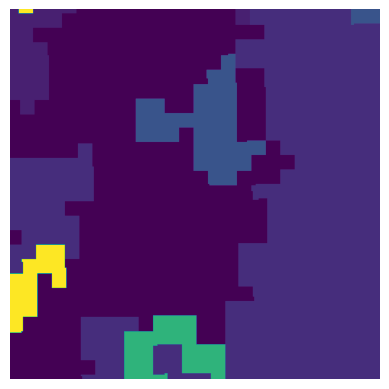

In [64]:
tiff_mask = '/home/ahmedemam576/greybox/corine_images/new_masks/anthropo_5.52111-59.46264_0'
import matplotlib.pyplot as plt
import tifffile as tiff

# Load the TIFF image
image = tiff.imread(tiff_mask)
print(image.shape)
# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Optional to hide axis ticks
plt.show()


In [67]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


### Fine tunning pretrained segmentation model deeplapv3

In [74]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
        
        self.data = pd.read_csv(csv_file)
        
        
        #the scene input images and the target segmentation maps both have the same name but in different folder
        
        
        
        self.image_paths = self.data['file']
        self.image_folder = image_folder
        self.target_folder = target_folder
        
        
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
  

        
        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)

        
        # Open the image using PIL
        image = tiff.imread(image_path)
        #choos ethe number of channels you need
        image= image[:,:,:3]

        image = image.astype('uint8')
        
        #
        
        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)
        target = np.transpose(target, (1,2,0))





        target = cv2.resize(target, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        #target = target.astype('uint8')
        
        ## turning the ground truth segmenation mask into a (L,W,CLASSES) one hot-hot encoded matrix
        #target = Image.fromarray(target)
        #target = target.resize((512,512))
        
        
        

        if self.transform:
            
            image = self.transform(image)
            target = self.transform_target(target)
            
            
            

        return image, target

    def __len__(self):
        return len(self.image_paths)
    #-----------------------------------------------------------------------------------#

# Define the paths to your training data


# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and set it to training mode

model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
model.train()
model.to('cuda')

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    transforms.ToPILImage(),
    
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

#transforms.ToPILImage(),
#transform_target =transforms.Compose([transforms.Resize((512, 512)),
#                                         transforms.ToTensor()])

transform_target = transforms.ToTensor()

#---------------------------------------------------------------------------------------------------#

csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/'
    
# Create the custom dataset
dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in tqdm(dataloader):
        
        optimizer.zero_grad()
        images, targets = images.cuda(), targets.cuda()
        # Forward pass
        outputs = model(images)        
        loss = criterion(outputs['out'], targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_model.pth')


/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 46%|████████████████▍                   | 5449/11960 [54:16<1:04:51,  1.67it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# ----------------------------------------------------------------------------------------------------------

## loading the weights to segmentation mask

In [14]:
import torch
import torchvision.models as models
from torchvision.models import segmentation

# Create an instance of the DeepLabv3 model
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)  # Replace 'num_classes' with your desired number of classes

# Load the saved checkpoint
checkpoint_path = 'fine_model_ep8_BS_4.pth'  # Replace with the actual path to your saved checkpoint file

model.load_state_dict(torch.load(checkpoint_path))



# Optionally, load other items from the checkpoint if needed
# For example, you can load the optimizer state_dict, scheduler state_dict, etc.

# Set the model to evaluation mode
model.eval()
num_params = sum(p.numel() for p in model.parameters())

print("Number of parameters: ", num_params)


# Now you can use the loaded model for inference or further training


Number of parameters:  42009728


## feed the seen images to the segmentation mask

## teach the student from the teacher's predictions

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

        '''self.mp = nn.MaxPool2d(2)
        self.dc = double_conv(in_ch, out_ch)'''

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
import torch.nn.functional as F



class UNet(nn.Module):
    def __init__(self, channel_depth, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, channel_depth)
        self.down1 = down(channel_depth, channel_depth*2)
        self.down2 = down(channel_depth*2, channel_depth*4)
        self.down3 = down(channel_depth*4, channel_depth*8)
        self.down4 = down(channel_depth*8, channel_depth*8)
        self.up1 = up(channel_depth*16, channel_depth*4)
        self.up2 = up(channel_depth*8, channel_depth*2)
        self.up3 = up(channel_depth*4, channel_depth)
        self.up4 = up(channel_depth*2, channel_depth)
        self.outc = outconv(channel_depth, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
        #return x

class UNet16(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up1 = up(256, 128)
        self.up2 = up(128, 64)
        self.up3 = up(64, 32)
        self.up4 = up(32, 16)
        self.outc = outconv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)
        #return x


In [27]:
student = UNet(channel_depth = 16, n_channels = 3, n_classes = 43)

num_params = sum(p.numel() for p in student.parameters())

print("Number of parameters: ", num_params)

Number of parameters:  840491


##  Dataset for the teacher

In [30]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2


#dataloader for the teacher

class Train_Dataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
        
        self.data = pd.read_csv(csv_file)
        
        
        #the scene input images and the target segmentation maps both have the same name but in different folder
        
        
        
        self.image_paths = self.data['file']
        self.image_folder = image_folder
        self.target_folder = target_folder
        
        
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
  

        
        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)

        
        # Open the image using PIL
        image = tiff.imread(image_path)
        #choos ethe number of channels you need
        image= image[:,:,:3]

        image = image.astype('uint8')
        
        #
        
        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)
        target = np.transpose(target, (1,2,0))





        target = cv2.resize(target, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        #target = target.astype('uint8')
        
        ## turning the ground truth segmenation mask into a (L,W,CLASSES) one hot-hot encoded matrix
        #target = Image.fromarray(target)
        #target = target.resize((512,512))
        
        
        

        if self.transform:
            
            image = self.transform(image)
            target = self.transform_target(target)
            
            
            

        return image, target

    def __len__(self):
        return len(self.image_paths)
    #-----------------------------------------------------------------------------------#


    
    
    
    
    




## initialize the models and the dataloader

In [ ]:
# Define the paths to your training data


# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and set it to training mode

model = segmentation.deeplabv3_resnet50(pretrained=False)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
model.train()
model.to('cuda')

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    transforms.ToPILImage(),
    
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

#transforms.ToPILImage(),
#transform_target =transforms.Compose([transforms.Resize((512, 512)),
#                                         transforms.ToTensor()])

transform_target = transforms.ToTensor()

#---------------------------------------------------------------------------------------------------#

csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/'
    
# Create the custom dataset
dataset = Train_Dataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


                #############################################################################
    

## loss functions 

In [2]:
import torch
import torch.nn.functional as F

#NOTE: all verifications for the size is left

T = 5
alpha = 0.9


def dice_loss(output, gt, smooth = 1):
    output = output.clamp(min = 0, max = 1)
    intersection = torch.sum(gt*output)
    union = torch.sum(gt) + torch.sum(output)
    dice = 1 -((2*intersection+smooth) / (union + smooth))
    return dice

def general_loss(student_output, gt):
    #use torch.nn.CrossENtropyLoss()
    loss = dice_loss(student_output, gt)
    return loss

def pixel_wise_loss(student_output, teacher_output):
    N,C,W,H = student_output.shape

    #what would happen if we use softmax?
    pred_T = torch.sigmoid(teacher_output/T)
    pred_S = torch.sigmoid(student_output/T).log()

    #criterion = torch.nn.KLDivLoss(reduction = 'batchmean')
    #KLDloss = - criterion(pred_S, pred_T)
    #TODO: map this to KLDL
    #KDloss = - sum(p * log (p/q)) ---> refer notes page 15 - 16 
    #Pixelwise loss = sum(-p*logq)
    #KLDiv = relative entropy
    pixelwise_loss = (- pred_T * pred_S)

    return  torch.sum(pixelwise_loss) / (W*H)

def loss_fn_kd(student_output, teacher_output, gt ):
    '''student_output = student_output.round() 
    student_output[student_output<0] = 0
    gt = torch.clamp(gt, min = 0, max = 1)
    teacher_output = torch.clamp(teacher_output, min = 0, max = 1)'''

    student_output = student_output.clamp(min = 0, max = 1)
    teacher_output = teacher_output.clamp(min = 0, max = 1)


    student_loss = general_loss(student_output, gt)
    kd_loss = pixel_wise_loss(student_output, teacher_output)
    #not sure about using T, also check KLD
    loss = (student_loss*(1-alpha) + (kd_loss)*(alpha)) # as per structured KD paper
    return loss    
    
    

## fetch the teacher predictions and training loop for the stedent

In [ ]:
def fetch_teacher_outputs(teacher, train_loader):
    print('-------Fetch teacher outputs-------')
    teacher.eval().cuda() #no stochasticity heremashy 
    #list of tensors
    teacher_outputs = []
    with torch.no_grad():
        #trainloader gets bs images at a time. why does enumerate(tl) run for all images?
        for i, img in enumerate(train_loader):
            print(i, 'i')
            '''img = img[0, :, :, :, :]
            gt = gt[0, :, :, :, :]'''
            if torch.cuda.is_available():
                img = img.cuda()
            output = teacher(img)
            teacher_outputs.append(output)
    return teacher_outputs

                 #############################################################################



def train_student(student, teacher_outputs, optimizer, train_loader):
    print('-------Train student-------')
    #called once for each epoch
    student.train().cuda()

    summ = []
    for i, (img, gt) in enumerate(train_loader):
        teacher_output = teacher_outputs[i]
        if torch.cuda.is_available():
            img, gt = img.cuda(), gt.cuda()
            teacher_output = teacher_output.cuda()

        img, gt = Variable(img), Variable(gt)
        teacher_output =  Variable(teacher_output)

        output = student(img)

        #TODO: loss is wrong
        loss = loss_fn_kd(output, teacher_output, gt)    

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        if i % summary_steps == 0:
            #do i need to move it to CPU?
            output = output.detach().cpu()
            gt = gt.detach().cpu()
            metric = dice_loss(output, gt)
            summary = {'metric' : metric.item(), 'loss' : loss.item()}
            summ.append(summary)
    
    #print('Average loss over this epoch: ' + np.mean(loss_avg))
    mean_dice_coeff =  np.mean([x['metric'] for x in summ])
    mean_loss = np.mean([x['loss'] for x in summ])
    print('- Train metrics:\n' + '\tMetric:{}\n\tLoss:{}'.format(mean_dice_coeff, mean_loss))
    #print accuracy and los

## evaluate the student on the evaluation dataset

In [ ]:
def evaluate_kd(student, val_loader):
    print('-------Evaluate student-------')
    student.eval().cuda()

    #criterion = torch.nn.BCEWithLogitsLoss()
    loss_summ = []
    with torch.no_grad():
        for i, (img, gt) in enumerate(val_loader):
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = student(img)
            output = output.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)

            loss_summ.append(loss.item())

    mean_loss = np.mean(loss_summ)
    print('- Eval metrics:\n\tAverage Dice loss:{}'.format(mean_loss))
    return mean_loss

## complete training loop

In [ ]:


min_loss = 100

teacher = UNet(channel_depth = 32, n_channels = 3, n_classes=1)
student = UNet(channel_depth = 16, n_channels = 3, n_classes=1)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)

#load teacher and student model
teacher.load_state_dict(torch.load(teacher_weights))
#student.load_state_dict(torch.load(student_weights))

#NV: add val folder
train_list = glob.glob('/home/nirvi/Internship_2020/Carvana dataset/train/train1/*jpg')
val_list = glob.glob('/home/nirvi/Internship_2020/Carvana dataset/val/val1/*jpg')

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#2 tensors -> img_list and gt_list. for batch_size = 1 --> img: (1, 3, 320, 320); gt: (1, 1, 320, 320)
train_loader = torch.utils.data.DataLoader(
    dataset.listDataset(train_list,
    shuffle = False,
    transform = tf,
    ),
    batch_size = 1
)


val_loader = torch.utils.data.DataLoader(
    dataset.listDataset(val_list,
    shuffle = False,
    transform = tf,
    ),
    batch_size = 1
)

#train_and_evaluate_kd:
#get teacher outputs as list of tensors
teacher_outputs = fetch_teacher_outputs(teacher, train_loader)
print(len(teacher_outputs))
for epoch in range(num_of_epochs):
    #train the student
    print(' --- student training: epoch {}'.format(epoch+1))
    train_student(student, teacher_outputs, optimizer, train_loader)

    #evaluate for one epoch on validation set
    val = evaluate_kd(student, val_loader)
    if(val < min_loss):
        min_loss = val
        #TODO: make min as the val loss of teacher
        print('New best!!')


    #if val_metric is best, add checkpoint

    torch.save(student.state_dict(), 'checkpoints/0.9/16/CP{}.pth'.format(epoch+1))
    print("Checkpoint {} saved!".format(epoch+1))
    scheduler.step()


## Function to produce a list of segmentation maps, each coming from a stochastic model

In [37]:
def mc_dropout(model, x, len_samples):
    model.train()
    model = model.to('cuda')
    x = x.to('cuda')
    
    for i in range(len_samples):
        output = model(x)
        output = output['out']
        print('output shape----->',output.shape)
        
        
    return output
        
torch.cuda.empty_cache()



In [3]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F


class CustomDataset(Dataset):
            def __init__(self, csv_file, image_folder, target_folder,transform_image=None):
                
                self.data = pd.read_csv(csv_file)
                
                
                #the scene input images and the target segmentation maps both have the same name but in different folder
                
                
                
                self.image_paths = self.data['file']
                #self.image_paths = self.image_paths[:10] for testing and debugging
                self.image_folder = image_folder
                self.target_folder = target_folder
                
                
                self.transform = transform
 

            def __getitem__(self, index):
        

                
                # Construct the complete image path by joining the folder path and image name
                image_name = self.image_paths[index] 
                image_path = os.path.join(self.image_folder, image_name)

                
                # Open the image using PIL
                image = tiff.imread(image_path)
                #choos ethe number of channels you need
                image= image[:,:,:3]

                image = image.astype('uint8')
                
                #
                
                target_path = os.path.join(self.target_folder, image_name)
                target = tiff.imread(target_path)
                target = np.transpose(target, (1,2,0))





                target = cv2.resize(target, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

                #target = target.astype('uint8')
                
                ## turning the ground truth segmenation mask into a (L,W,CLASSES) one hot-hot encoded matrix
                #target = Image.fromarray(target)
                #target = target.resize((512,512))
                
                
                

                if self.transform:
                    
                    image = self.transform(image)
  
                    
                    
                    

                return image, target

            def __len__(self):
                return len(self.image_paths)

'''
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
checkpoint_path = 'fine_model_ep8_BS_4.pth'  # Replace with the actual path to your saved checkpoint file

model.load_state_dict(torch.load(checkpoint_path))'''



csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/'


# Create the custom dataset
from torch.utils.data import DataLoader, random_split


dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform)


train_size = int(0.9955 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for the training and test subsets
num_samples = 3
batch_size=10


train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False,drop_last=True)
# Create the data loader
dataloader = DataLoader(dataset, batch_size=batch_size , shuffle=True, drop_last=True)




'''
pretrained_model = model
input_data = dataset


model = model.to('cuda')'''

"\npretrained_model = model\ninput_data = dataset\n\n\nmodel = model.to('cuda')"

### run the model several times using MC droput, and store the results in a tensor of the shape (no.of batches, number of MCruns, channels(classes),width, hight )

In [2]:
# Define your Monte Carlo Dropout function

def mc_dropout(model, x, num_samples):
    torch.cuda.empty_cache()
    with torch.no_grad():
        model.train()
        x = x.to('cuda')
        #print(x.shape)
        #outputs = torch.zeros((num_samples,) + x.shape[1:])
        
        preds = [(model(x)['out'].cpu().detach()) for i in range(num_samples)]
        #pred = model(x)['out'].cpu().detach()
        #print('model output is -->',model(x)['out'].size)
        #preds.append(pred)
        
     
    return preds



# Create an empty tensor to store the outputs


# Create an empty tensor with the desired shape

all_predictions = []
print(len(test_dataloader))
# Loop over the input data
for imgs , target in tqdm(test_dataloader):
    batch_predictions = []
    pred_sets = mc_dropout(pretrained_model, imgs, num_samples)
    img_predictions = torch.stack(pred_sets, dim=1)
    #batch_predictions.append(img_predictions)
    #batch_predictions.append(pred_sets)

    

  
  
    
    #batch_predictions = torch.stack(batch_predictions, dim=0)
    
    all_predictions.append(img_predictions)
    

    
monte_carlo_predictions = torch.cat(all_predictions, dim=0)
print('mc predcs--->',monte_carlo_predictions.shape)
'''# Calculate uncertainty maps
variance = torch.var(outputs, dim=1)  # Variance across the Monte Carlo samples
uncertainty_maps = 1 - torch.max(F.softmax(variance, dim=1), dim=1)[0]  # Uncertainty maps

# Print the shape of the uncertainty maps tensor
print(uncertainty_maps.shape)'''

NameError: name 'test_dataloader' is not defined

In [23]:
import torch
import torch.nn.functional as F

def mIOU(pred, label, num_classes=43):
    #pred = F.softmax(pred, dim=1)  # Convert raw logits to probabilities
    pred = torch.argmax(pred, dim=1)
    label = torch.argmax(label,dim=1)
    print(label)
    # Convert to class indices
    print('pred',pred.shape)
    print('label',torch.max(label, dim= 0))
    iou_list = []
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)

        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else:
            intersection_now = (pred_inds & target_inds).long().sum().item()
            union_now = (pred_inds | target_inds).long().sum().item()
            iou_now = float(intersection_now) / (float(union_now) + 1e-8)

        iou_list.append(iou_now)

    present_iou_list = [iou for iou in iou_list if not torch.isnan(iou)]

    return sum(present_iou_list) / len(present_iou_list)

def calculate_dice(y_pred, y_true):
    intersection = torch.logical_and(y_pred, y_true).sum(dim=(1, 2, 3)).float()
    dice = (2.0 * intersection) / (y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3)) + 1e-8)
    dice = dice.mean()
    return dice.item()

# Assuming you have loaded your model and validation dataset
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Sequential(
        nn.Conv2d(256, 43, kernel_size=1),
        nn.Sigmoid() )
model.to('cuda')
checkpoint_path = '/home/ahmedemam576/greybox/corine_images/pretrained_CEandexternalSigmoid19.pth'  # Replace with the actual path to your saved checkpoint file
model.load_state_dict(torch.load(checkpoint_path))


########



train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False,drop_last=True)
# DataLoader for the validation dataset

model.eval()
iou_scores = []
dice_scores = []

with torch.no_grad():
    for images, targets in val_dataloader:
        images, targets = images.cuda(), targets.cuda()
        targets = targets.permute(0,3,1,2)
        # Forward pass
        outputs = model(images)
        predicted_masks = outputs['out']  # Assuming you have a threshold for prediction
        predicted_masks = predicted_masks.to('cuda')
        targets = targets.to('cuda')
        iou = mIOU(predicted_masks, targets)
        dice = calculate_dice(predicted_masks, targets)

        iou_scores.append(iou)
        dice_scores.append(dice)

mean_iou = sum(iou_scores) / len(iou_scores)
mean_dice = sum(dice_scores) / len(dice_scores)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Score: {mean_dice:.4f}")

/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[[ 0,  0,  0,  ..., 19, 19, 19],
         [ 0,  0,  0,  ..., 19, 19, 19],
         [ 0,  0,  0,  ..., 19, 19, 19],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[19, 19, 19,  ...,  0,  0,  0],
         [19, 19, 19,  ...,  0,  0,  0],
         [19, 19, 19,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0, 

TypeError: isnan(): argument 'input' (position 1) must be Tensor, not float

In [ ]:
def calculate_iou(pred, target, num_classes):
    iou_sum = 0
    for class_id in range(num_classes):
        intersection = np.logical_and(target == class_id, pred == class_id)
        union = np.logical_or(target == class_id, pred == class_id)
        iou = np.sum(intersection) / np.sum(union)
        iou_sum += iou
    mean_iou = iou_sum / num_classes
    return mean_iou


In [ ]:
num_classes = 43

# Initialize an empty list to store the transformed labels
y_class_encoded = []

# For loop to iterate through the dataset and convert one-hot encoded labels to class encoded
for image, one_hot_label in tqdm(train_dataloader):
    one_hot_label = one_hot_label.permute(0, 3, 1, 2)
    
    # Find the class index by finding the position of 1 in the one-hot encoded label
    class_index = torch.argmax(one_hot_label, dim=1)
    #print(class_index.shape)
    # Append the class index to the list of class encoded labels
    y_class_encoded.append(class_index)
    #print(len(y_class_encoded))
# Convert the list of class indices into a tensor
# The shape of the tensor will be: (num_images, height, width)
stacked_tensor = torch.cat(y_class_encoded, dim=0)
print(stacked_tensor.shape)
# Save the stacked tensor to a file (e.g., a .pt or .pth file)
torch.save(stacked_tensor, "class_indexed_GT.pt")

100%|█████████████████████████████████████| 11906/11906 [18:43<00:00, 10.60it/s]


### visulaize and evaluate trained models

In [1]:
# dataset and dataloaders
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import tifffile as tiff
import cv2
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):

        self.data = pd.read_csv(csv_file)


        #the scene input images and the target segmentation maps both have the same name but in different folder



        self.image_paths = self.data['file']
        self.image_paths = self.image_paths[:] #for testing and debugging
        self.image_folder = image_folder
        self.target_folder = target_folder


        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):



        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)


        # Open the image using PIL
        image = tiff.imread(image_path)
        #choos ethe number of channels you need
        image= image[:,:,:3]/10000


        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)






        if self.transform:

            image = self.transform(image)
            target = self.transform_target(target)



        return image, target

    def __len__(self):
        return len(self.image_paths)
csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/new_masks/'

# Create the custom dataset
transform = transforms.Compose([

    transforms.ToTensor() 
])


transform_target = transforms.ToTensor()
dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)
batch_size = 40
# Create the data loader

train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last= True)

In [2]:
# loading the model and weights
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Sequential(
nn.Conv2d(256, 43, kernel_size=1))
PATH= 'allparm_CE_classindexedGT99.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

images batch shape is torch.Size([40, 3, 256, 256]) and targets batch shape is torch.Size([40, 1, 256, 256])
image shape is torch.Size([3, 256, 256]) and target shape is torch.Size([1, 256, 256])
output shape is torch.Size([40, 43, 256, 256])
output shape before softmax is torch.Size([43, 256, 256])
output prob shape after sigmoid  is torch.Size([43, 256, 256])
binary_predictions shape after threshold is torch.Size([43, 256, 256])
predictions shape after argmax is torch.Size([256, 256])
preicted classes  tensor([21, 22, 23, 39])
ground truth classes tensor([21, 22, 34, 39])
pred shape, torch.Size([256, 256])
target shape,  torch.Size([256, 256])
iou -----> tensor(93.3798)  % 


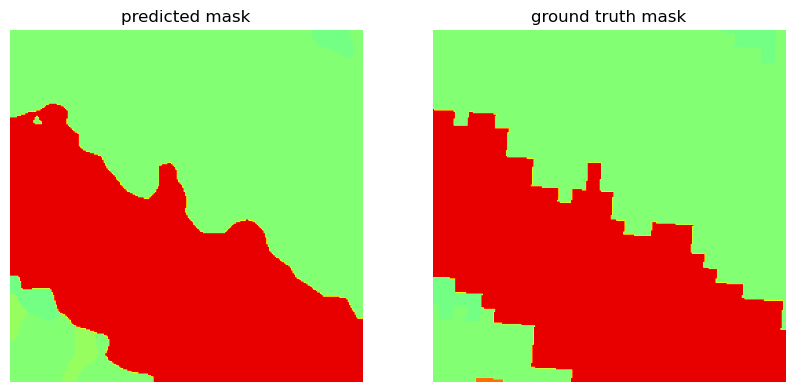

In [59]:
import matplotlib.pyplot as plt

from torch import tensor
from torchmetrics.functional.classification import multiclass_jaccard_index, multilabel_jaccard_index
images, targets = next(iter(dataloader))
print(f'images batch shape is {images.shape} and targets batch shape is {targets.shape}')
image, target = images[0], targets[0]
print(f'image shape is {image.shape} and target shape is {target.shape}')


input_tensor = images.float()
input_tensor
model.eval()
# Make predictions

with torch.no_grad():
        outputs = model(input_tensor)['out']
    
print(f'output shape is {outputs.shape}')
output = outputs[0]
print(f'output shape before softmax is {output.shape}')# .detach().cpu().numpy()
target = target[0]#.detach().cpu().numpy()
output_prob = torch.sigmoid(output)

print(f'output prob shape after sigmoid  is {output_prob.shape}')

#binary_predictions = (output_prob > 0.5).cpu().numpy().astype(int)
print(f'binary_predictions shape after threshold is {output_prob.shape}')

prediction = torch.argmax(output_prob, dim = 0)
print(f'predictions shape after argmax is {prediction.shape}')





target = target.long()

preds = prediction.long()

print('preicted classes ',torch.unique(preds))
print('ground truth classes',torch.unique(target))
print('pred shape,',preds.shape)
print('target shape, ', target.shape)
print('iou ----->',multiclass_jaccard_index(preds, target, num_classes= 43, average='weighted')*100, ' % ')




# Visualize the original image and predicted mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].imshow(target, cmap='jet', vmin=0, vmax=43)  
axs[1].set_title('ground truth mask')
axs[1].axis('off')

axs[0].imshow(prediction, cmap='jet', vmin=0, vmax=43)
axs[0].set_title('predicted mask')
axs[0].axis('off')



plt.show()

### validate the model performace using test dataset

images batch shape is torch.Size([40, 3, 256, 256]) and targets batch shape is torch.Size([40, 1, 256, 256])
image shape is torch.Size([3, 256, 256]) and target shape is torch.Size([1, 256, 256])
output shape is torch.Size([40, 43, 256, 256])
output shape before softmax is torch.Size([43, 256, 256])
output prob shape after sigmoid  is torch.Size([43, 256, 256])
binary_predictions shape after threshold is torch.Size([43, 256, 256])
predictions shape after argmax is torch.Size([256, 256])
preicted classes  tensor([11, 19, 22, 23, 27])
ground truth classes tensor([11, 19, 22, 23])
pred shape, torch.Size([256, 256])
target shape,  torch.Size([256, 256])
iou -----> tensor(76.4240)  % 


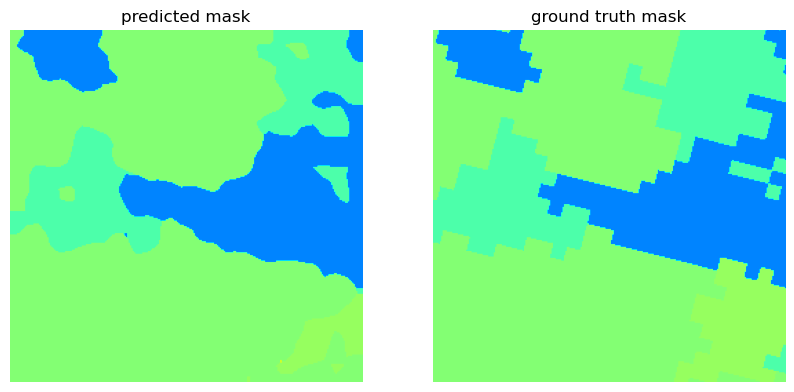

In [56]:
import matplotlib.pyplot as plt

from torch import tensor
from torchmetrics.functional.classification import multiclass_jaccard_index, multilabel_jaccard_index

images, targets = next(iter(test_dataloader))
print(f'images batch shape is {images.shape} and targets batch shape is {targets.shape}')
image, target = images[0], targets[0]
print(f'image shape is {image.shape} and target shape is {target.shape}')
###################################

input_tensor = images.float()

model.eval()
with torch.no_grad():
        outputs = model(input_tensor)['out']
    
print(f'output shape is {outputs.shape}')
output = outputs[0]
print(f'output shape before softmax is {output.shape}')# .detach().cpu().numpy()
target = target[0]#.detach().cpu().numpy()
output_prob = torch.sigmoid(output)

print(f'output prob shape after sigmoid  is {output_prob.shape}')

#binary_predictions = (output_prob > 0.5).cpu().numpy().astype(int)
print(f'binary_predictions shape after threshold is {output_prob.shape}')

prediction = torch.argmax(output_prob, dim = 0)
print(f'predictions shape after argmax is {prediction.shape}')
target = target.long()

preds = prediction.long()

print('preicted classes ',torch.unique(preds))
print('ground truth classes',torch.unique(target))
print('pred shape,',preds.shape)
print('target shape, ', target.shape)
print('iou ----->',multiclass_jaccard_index(preds, target, num_classes= 43, average='weighted')*100, ' % ')



#############################
# Visualize the original image and predicted mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].imshow(target, cmap='jet', vmin=0, vmax=43)  
axs[1].set_title('ground truth mask')
axs[1].axis('off')

axs[0].imshow(prediction, cmap='jet', vmin=0, vmax=43)
axs[0].set_title('predicted mask')
axs[0].axis('off')
##

##
plt.show()

In [60]:
asd

NameError: name 'asd' is not defined